# Домашняя работа №2 по AB-тестам

<details>
  <summary>📝 Формулировка задания </summary>

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt (5 баллов)

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt (5 баллов)
- логарфимированной метрике cart_added_cnt (5 баллов)
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)


В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped
(+ 5 балла за обьяснения и выводы)


3. Реализовать разбивку на бакеты любым (правильным) способом, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные) (5 баллов)
- на метрике cart_added_cnt (5 баллов)


4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)
подсчитать результаты для случая без постстратификации и с постстратификацией. (дисперсию и среднее)
- проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)

(+ 5 балла за обьяснения и выводы)

</details>

In [239]:
# Импорты необходимых библиотек
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from tqdm import tqdm
from base64 import b64encode
import hashlib

import scipy.stats
from scipy.stats import ttest_ind, mannwhitneyu

In [240]:
# Дополнительные функции с лекций
def salt_generator(salt=None):
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')

def groups_splitter(df, user_salt=None):
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

### Загрузка данных

Метрики:
   - is_viewed - айтем товара просмотрен
   - products_viewed_cnt - количество уникальных просмотренных айтемов
   - price_sum - суммарная цена товаров
   - is_cart_added - товар добавлен в корзину
   - is_purchased - товар куплен
   - cart_added_cnt - количество товаров, добавленных в корзину
   - purchased_cnt - количество купленных товаров

In [242]:
shop_metrics_new = pd.read_csv('./data/shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('./data/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('./data/shop_df_users.csv').drop(columns='Unnamed: 0')

In [243]:
display(shop_metrics_new.head())
display(shop_metrics_new.describe())
print('shop_metrics_new: ', shop_metrics_new.shape)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0


,user_id,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
count,2.225210e+05,222521.0,222521.000000,222521.000000,222521.0,222521.0,222521.000000,222521.000000
mean,1.515916e+18,1.0,1.540286,245.955802,0.0,0.0,0.136796,0.068928
std,2.307032e+07,0.0,2.505409,859.596236,0.0,0.0,0.634541,0.344592
min,1.515916e+18,1.0,1.000000,0.370000,0.0,0.0,0.000000,0.000000
25%,1.515916e+18,1.0,1.000000,27.320000,0.0,0.0,0.000000,0.000000
50%,1.515916e+18,1.0,1.000000,70.600000,0.0,0.0,0.000000,0.000000
75%,1.515916e+18,1.0,1.000000,217.960000,0.0,0.0,0.000000,0.000000
max,1.515916e+18,1.0,419.000000,138578.950000,0.0,0.0,75.000000,25.000000


shop_metrics_new:  (222521, 9)


In [244]:
display(shop_metrics_old.head())
print('shop_metrics_old: ', shop_metrics_old.shape)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0


shop_metrics_old:  (406863, 9)


In [245]:
display(shop_users_info.head())
print('shop_users_info: ', shop_users_info.shape)

,user_id,user_age,user_sex
0,1515915625519388267,41,f
1,1515915625519380411,84,m
2,1515915625513238515,41,m
3,1515915625519014356,25,m
4,1515915625510743344,42,m


shop_users_info:  (407283, 3)


### Визуализация данных (EDA)

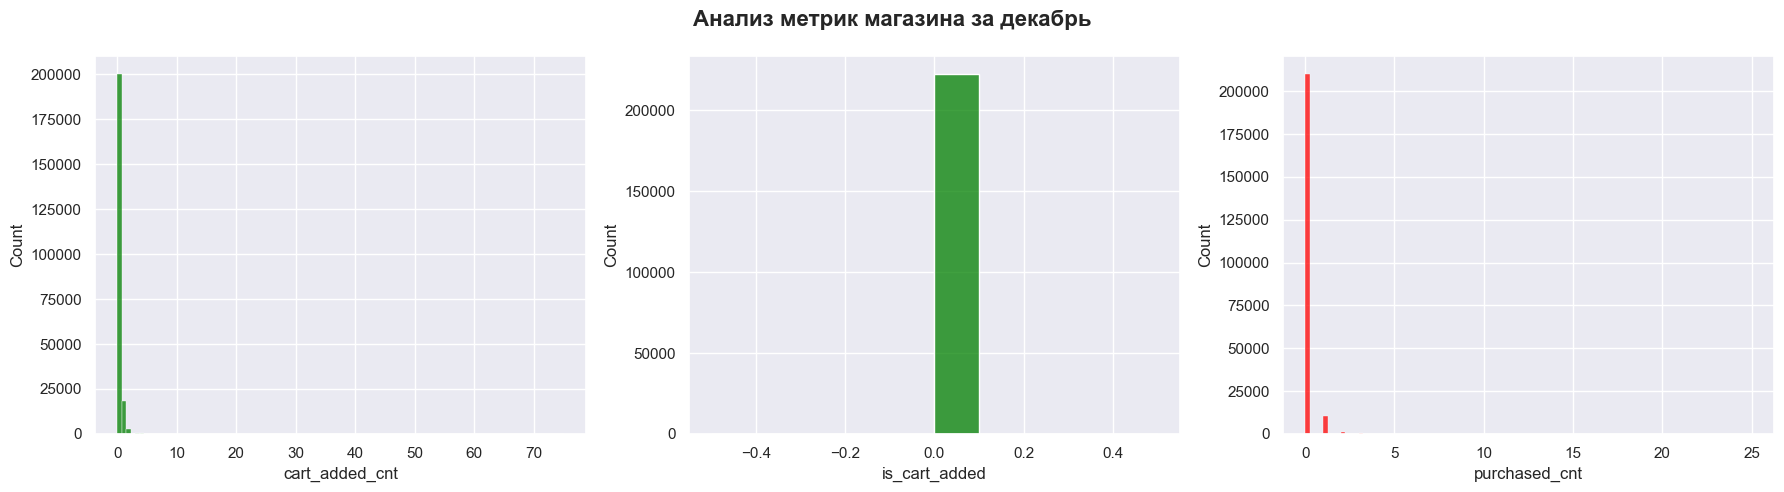

In [246]:
# Создаем фигуру и оси
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Строим графики
sns.histplot(data=shop_metrics_new, x='cart_added_cnt', bins=100, color='green', ax=axes[0])
sns.histplot(data=shop_metrics_new, x='is_cart_added', bins=10, color='green', ax=axes[1])
sns.histplot(data=shop_metrics_new, x='purchased_cnt', bins=100, color='red', ax=axes[2])

# Настройка отступов и отображение
fig.suptitle("Анализ метрик магазина за декабрь", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

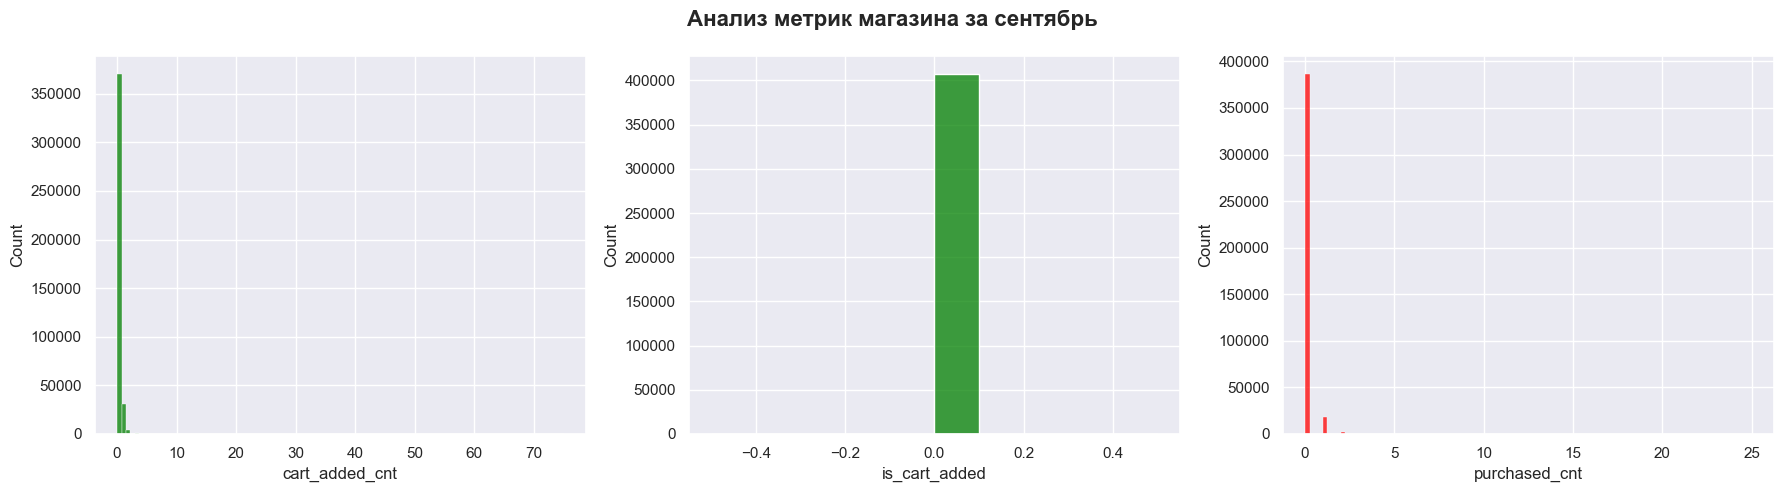

In [247]:
# Создаем фигуру и оси
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Строим графики
sns.histplot(data=shop_metrics_old, x='cart_added_cnt', bins=100, color='green', ax=axes[0])
sns.histplot(data=shop_metrics_old, x='is_cart_added', bins=10, color='green', ax=axes[1])
sns.histplot(data=shop_metrics_old, x='purchased_cnt', bins=100, color='red', ax=axes[2])

# Настройка отступов и отображение
fig.suptitle("Анализ метрик магазина за сентябрь", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Даннные неравномерны за оба месяца, причем сильно, что стоит учитывать при дальнейших экспериментах 

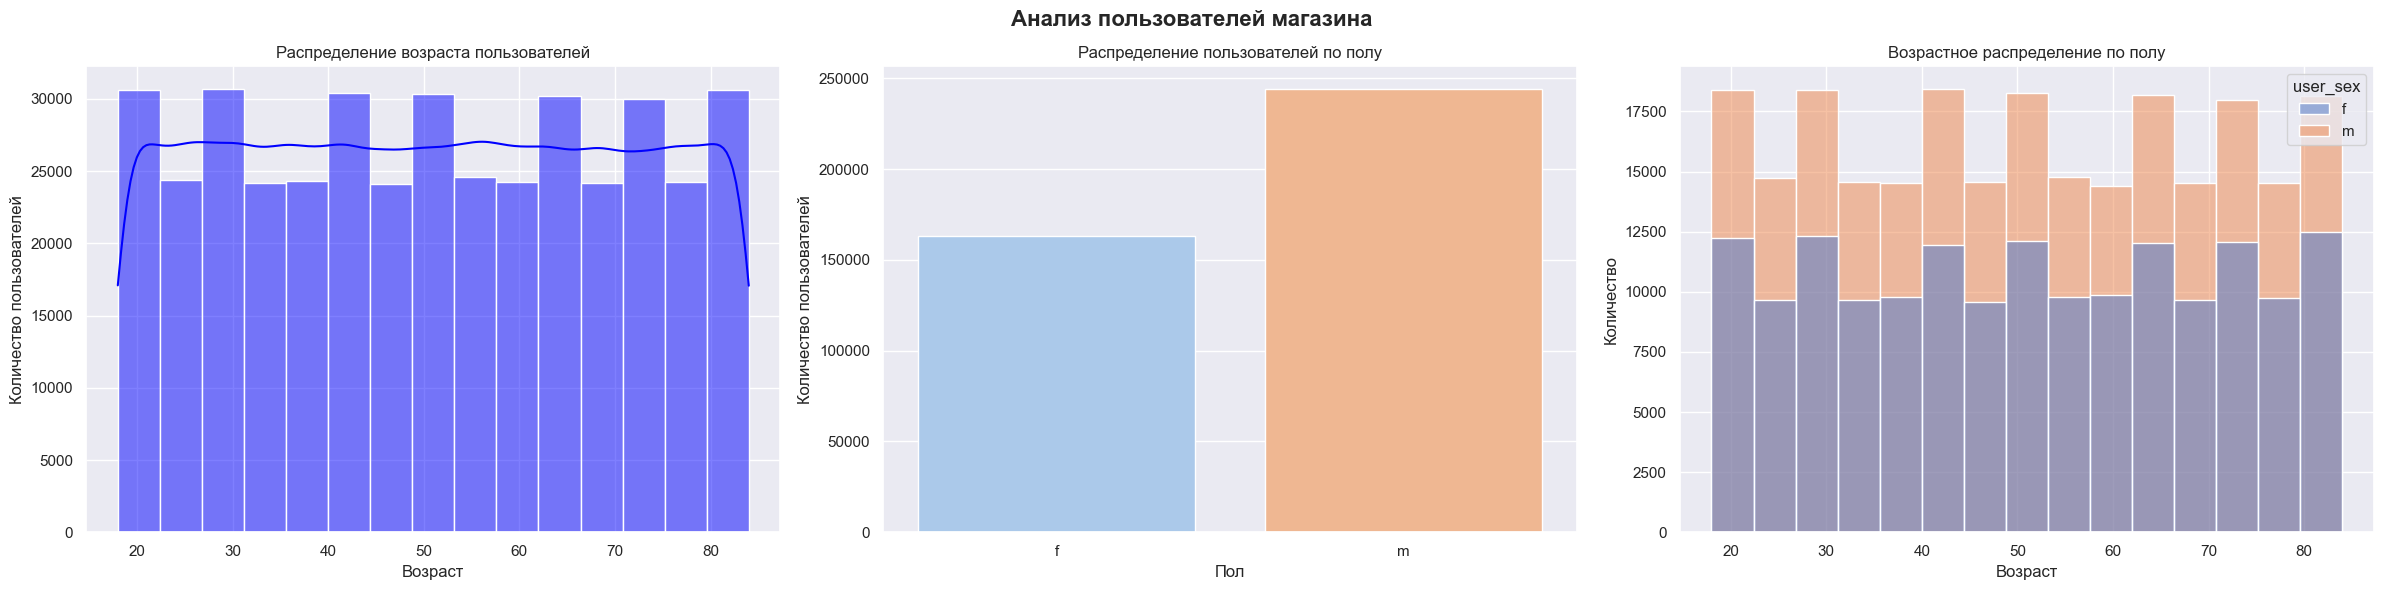

In [248]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Гистограмма распределения возраста
sns.histplot(data=shop_users_info, x='user_age', bins=15, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Распределение возраста пользователей')
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('Количество пользователей')

# Количество пользователей по полу
sns.countplot(data=shop_users_info, x='user_sex', hue='user_sex', palette='pastel', ax=axes[1], dodge=False)
axes[1].set_title('Распределение пользователей по полу')
axes[1].set_xlabel('Пол')
axes[1].set_ylabel('Количество пользователей')

# График распределения пользователей по возрасту и полу
sns.histplot(data=shop_users_info, x='user_age', hue='user_sex', bins=15, kde=False, palette='muted', ax=axes[2])
axes[2].set_title('Возрастное распределение по полу')
axes[2].set_xlabel('Возраст')
axes[2].set_ylabel('Количество')

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('Анализ пользователей магазина', fontsize=16, fontweight='bold')
plt.show()

### **1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:**
- метрике cart_added_cnt (5 баллов)

Посмотрим вначале на мощность и корректонсть t-test без ранговой трансформации, чтобы понимать на сколько она улучшило значения

In [249]:
shop = shop_metrics_new.drop(columns=['group'])
shop

,user_id,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,1,1,20.98,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...
222516,1515915625611023671,1,1,32.22,0.0,0.0,0,0
222517,1515915625611023730,1,1,219.94,0.0,0.0,0,0
222518,1515915625611024014,1,1,80.03,0.0,0.0,0,0
222519,1515915625611024020,1,1,64.92,0.0,0.0,0,0


100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]

 power: 69.0% , correctness: 96.39999999999999%


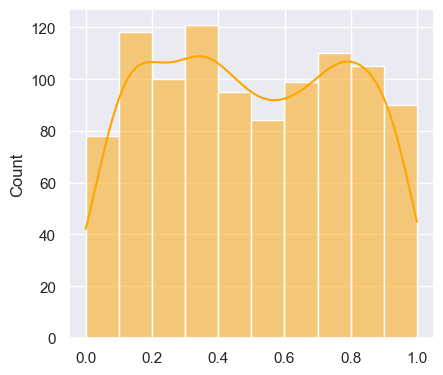

In [282]:
# мощность и корректность t-test для исходной метрики
correctness = []
power = []

for i in tqdm(range(1000)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    group_A  = new_df[(new_df['group'] == 'A')]['cart_added_cnt']
    group_B = new_df[(new_df['group'] == 'B')]['cart_added_cnt']
    vec_b_effect = group_B * 1.05
    p_cor, p_power = ttest_ind(group_A, group_B)[1], ttest_ind(group_A, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='orange', kde=True)

power = np.array(power)
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Тест работает корректно: в 96% случаев он не ошибается, когда эффекта нет.

Но его мощность (69%) недостаточно высока: в 30% случаев он не замечает реальный эффект. Для A/B-тестов лучше стремиться к мощности 80% и выше.

#### Применим ранговую трансформацию

In [251]:
# функция ранговой трансформации
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()
    return df

ranked = rank_transformation(shop_metrics_new[shop_metrics_new.group == 'A'],
                             shop_metrics_new[shop_metrics_new.group == 'B'], 'cart_added_cnt')

print('Колличество рангов:' , len(ranked['rank'].unique()))
print('Какие ранги сформировались? - ', ranked['rank'].unique())
ranked

Колличество рангов: 35
Какие ранги сформировались? -  [100038.5 219885.  209349.  221482.5 222462.  221968.5 222269.  222175.
 222483.  222490.5 222372.5 222405.5 222445.  222332.5 222472.  222503.5
 222497.5 222428.5 222512.5 222478.  222516.  222518.  222509.5 222514.
 222487.  222520.  222519.  222515.  222507.5 222521.  222501.  222506.
 222493.5 222517.  222511. ]


,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,100038.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,100038.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,100038.5
5,1515915625353400724,A,1,2,103.33,0.0,0.0,0,0,100038.5
7,1515915625353416040,A,1,13,1861.21,0.0,0.0,0,0,100038.5
...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,100038.5
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,100038.5
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,100038.5
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,100038.5


100%|██████████| 1000/1000 [06:14<00:00,  2.67it/s]

 power: 100.0% , correctness: 95.5%


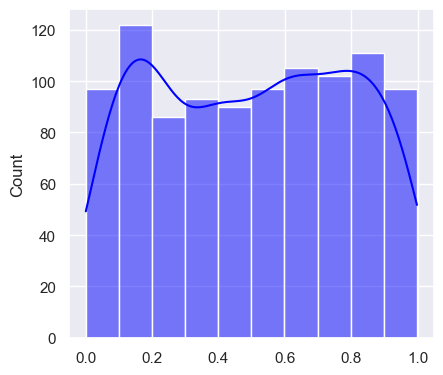

In [252]:
# мощность и корректность t-test для ранговой трансформации
correctness = []
power = []

for i in tqdm(range(1000)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    ranked_df = rank_transformation(new_df[new_df.group == 'A'], new_df[new_df.group == 'B'], 'cart_added_cnt')

    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']

    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05
    new_df_b = new_df[new_df.group == 'B'].drop(columns=['cart_added_cnt'])
    new_df_b['cart_added_cnt'] = list(vec_b_effect)

    ranked_df_effect = rank_transformation(new_df[new_df.group == 'A'], new_df_b, 'cart_added_cnt')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']


    p_cor, p_power = ttest_ind(vec_a, vec_b)[1], ttest_ind(vec_a_power, vec_b_power)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

#### Реализация теста Манна-Уитни

100%|██████████| 1000/1000 [05:26<00:00,  3.07it/s]

power: 100.0% , correctness: 94.10000000000001%


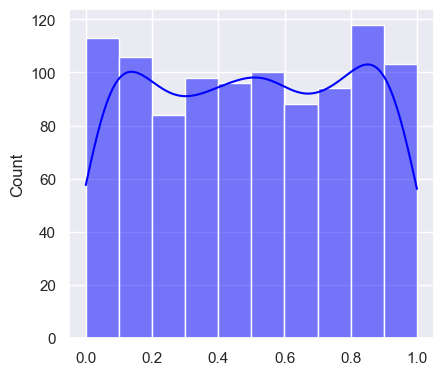

In [285]:
# Мощность и корректность Mann-Whitney теста
correctness = []
power = []

for i in tqdm(range(1000)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[new_df['group'] == 'A']['cart_added_cnt']
    vec_b = new_df[new_df['group'] == 'B']['cart_added_cnt']

    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05
    new_df_b = new_df[new_df.group == 'B'].copy()
    new_df_b['cart_added_cnt'] = vec_b_effect

    vec_a_power = new_df[new_df['group'] == 'A']['cart_added_cnt']
    vec_b_power = new_df_b['cart_added_cnt']

    p_cor, p_power = (
        mannwhitneyu(vec_a, vec_b, alternative='two-sided')[1],
        mannwhitneyu(vec_a_power, vec_b_power, alternative='two-sided')[1]
    )
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize': (4.7, 4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)

print(f'power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

#### `Сравнение ранговой` трансформации + t-test и теста Манна–Уитни

Оба метода показали 100% мощность, то есть отлично «ловят» 5%-й эффект. При этом корректность (вероятность не совершить ложноположительную ошибку) у рангового t-теста составила около 95.5%, а у Манна–Уитни — около 94.1%. Разница не слишком велика, однако на данных с сильным перекосом (большим количеством нулей и длинным «хвостом») тест Манна–Уитни традиционно считается более надёжным благодаря своей непараметрической природе.

Таким образом, оба метода хорошо подходят для обнаружения эффекта, но приоритет часто отдаётся `Манна–Уитни`, если метрика далека от нормального распределения и хочется минимизировать влияние выбросов и скошенности.

### **2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:**
- обычной метрике cart_added_cnt (5 баллов)
- логарфимированной метрике cart_added_cnt (5 баллов)
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)

В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped
(+ 5 балла за обьяснения и выводы)

In [254]:
# из лекций - для использования метрики CUPED
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()

import scipy.stats as stats
shop_metrics_new = pd.read_csv('./data/shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('./data/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('./data/shop_df_users.csv').drop(columns='Unnamed: 0')

#### 1. Обычная метрика `cart_added_cnt`

In [255]:
# Используем данные за декабрь и сентябрь
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

# применяем cuped 
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])
display(shop_metrics_all_cuped.head(5))

/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/3523451292.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.1327605 0.1327605 0.1327605 ... 0.1327605 0.1327605 0.1327605]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)


,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.132761
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.132761
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.132761
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,0.132761
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,0.132761


Такой вывод показыавет, что cuped преобразование должно быть хорошим - однако дальше видно, что он не намного уменьшил p-value. Такие результаты, возможно, связаны со скошенным распределеннием 

In [256]:
correlation = shop_metrics_all['cart_added_cnt'].corr(shop_metrics_all['cart_added_cnt_covariate'])
print(f"Корреляция между метрикой и ковариатой: {correlation:.3f}")

Корреляция между метрикой и ковариатой: 0.975


In [257]:
# Проверка равенства средних метрики до и после применения CUPED (разница уменьшения не большая)
ttest_original = ttest_ind(
    shop_metrics_all[shop_metrics_all.group == 'A']['cart_added_cnt'],
    shop_metrics_all[shop_metrics_all.group == 'B']['cart_added_cnt']
)
ttest_cuped = ttest_ind(
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped']
)

print(f'p-value оригинальной метрики: {ttest_original[1]}')
print(f'p-value метрики с CUPED: {ttest_cuped[1]}')

p-value оригинальной метрики: 0.1919716009958315
p-value метрики с CUPED: 0.1658736404876475


In [258]:
# Видим, что среднее не изменилось
print(f'Среднее: метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].mean()}, \
        Среднее: метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].mean()}')
print(f'Среднее: метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
        Среднее: метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}')

print('__' * 50)

# Видим, что дисперсия сильно уменьшилась - что должно быть хорошо для дальнейших вычислений
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].var()}')

print('__' * 50)

# Проверка равенства средних ковариаты в группах (равны)
print(f'Ковариата A: {shop_metrics_all[shop_metrics_all.group == "A"]["cart_added_cnt_covariate"].mean()}, \
        Ковариата B: {shop_metrics_all[shop_metrics_all.group == "B"]["cart_added_cnt_covariate"].mean()}')

Среднее: метрика_cuped A: 0.13638231572657294,         Среднее: метрика_cuped B: 0.1372102898471418
Среднее: метрика без cuped A: 0.1350419058398685,         Среднее: метрика без cuped B: 0.1385521582733813
____________________________________________________________________________________________________
метрика_cuped A: 0.018235183599645398,         метрика_cuped B: 0.02149536345539647
метрика без cuped A: 0.3805867322090304,         метрика без cuped B: 0.4247189893567569
____________________________________________________________________________________________________
Ковариата A: 0.14055748690723224,         Ковариата B: 0.14342625899280576


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/3523451292.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.1327605 0.1327605 0.1327605 ... 0.1327605 0.1327605 0.1327605]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)
  0%|          | 1/1000 [00:00<05:43,  2.91it/s]/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/3523451292.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.1327605 0.1327605 0.1327605 ... 0.1327605 0.1327605 0.1327605]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)
  0%|          | 2/1000 [00:00<05:39,  2.94it/s]/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/3523451292.py:16: FutureWarning: Setting an item o

 power: 100.0% , correctness: 94.69999999999999%


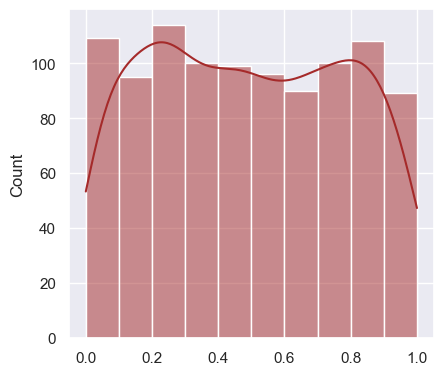

In [259]:
# мощность и корректность для CUPED
correctness = []
power = []

for i in tqdm(range(1000)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']

    vec_b_effect = vec_b * 1.05

    p_cor, p_power = ttest_ind(vec_a, vec_b)[1], ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

#### Предположение!
На лекциях вы говорили, что иногда для ковариаты берут иногда другие признаки, главное, чтобы они сильно коррелировали. Возможно если взять ковариатой метрику purchased_cnt или нормализовать cart_added_cnt(убрать выбросные перцептили) - картинка бы улучшилась. 

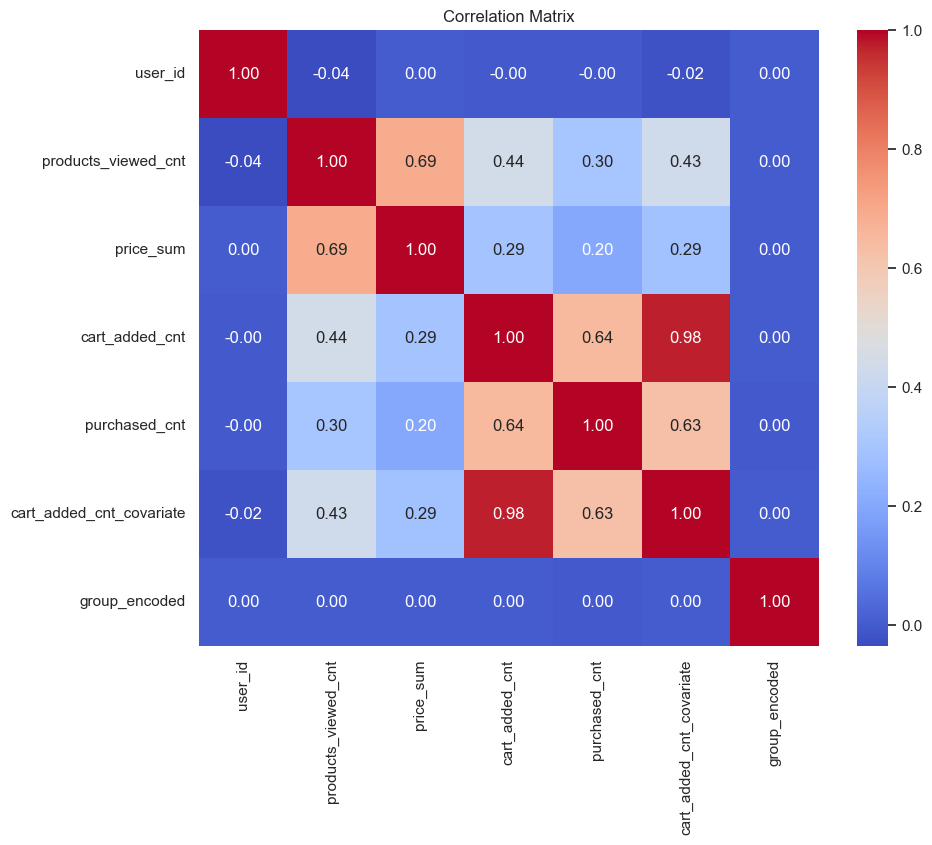

In [260]:
# Закодируем столбец 'group'
shop_metrics_all['group_encoded'] = shop_metrics_all['group'].map({'A': 0, 'B': 1})

# Удаляем исходный столбец 'group'
shop_metrics_all_2 = shop_metrics_all.drop(columns=['group']).drop(columns=['is_cart_added']).drop(columns=['is_purchased']).drop(columns=['is_viewed'])

# Построение матрицы корреляции
corr_matrix = shop_metrics_all_2.corr()

# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### 2. Логарифмированная метрика `cart_added_cnt`

In [261]:
# Используем данные за декабрь и сентябрь
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

# Применяем логарифмическое преобразование к столбцам
shop_metrics_all['cart_added_cnt'] = np.log1p(shop_metrics_all['cart_added_cnt'])
shop_metrics_all['cart_added_cnt_covariate'] = np.log1p(shop_metrics_all['cart_added_cnt_covariate'])

# Применяем CUPED
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])
display(shop_metrics_all_cuped.head(5))

/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/3523451292.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.08000403 0.08000403 0.08000403 ... 0.08000403 0.08000403 0.08000403]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)


,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0.0,0,0.0,0.080004
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0.0,0,0.0,0.080004
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0.0,0,0.0,0.080004
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0.0,0,0.0,0.080004
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0.0,0,0.0,0.080004


In [262]:
correlation = shop_metrics_all['cart_added_cnt'].corr(shop_metrics_all['cart_added_cnt_covariate'])
print(f"Корреляция между метрикой и ковариатой: {correlation:.3f}")

Корреляция между метрикой и ковариатой: 0.985


In [263]:
# Проверка равенства средних метрики до и после применения CUPED (разница уменьшения - теперь как надо!)
ttest_original = ttest_ind(
    shop_metrics_all[shop_metrics_all.group == 'A']['cart_added_cnt'],
    shop_metrics_all[shop_metrics_all.group == 'B']['cart_added_cnt']
)
ttest_cuped = ttest_ind(
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped']
)

print(f'p-value оригинальной метрики: {ttest_original[1]}')
print(f'p-value метрики с CUPED: {ttest_cuped[1]}')
print('__' * 50)

# Видим, что среднее не изменилось
print(f'Среднее: метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].mean()}, \
        Среднее: метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].mean()}')
print(f'Среднее: метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
        Среднее: метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}')

print('__' * 50)

# Видим, что дисперсия сильно уменьшилась еще сильнее чем в пункте 1
print(f'Дисперсия: метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].var()}, \
        Дисперсия: метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].var()}')
print(f'Дисперсия: метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].var()}, \
        Дисперсия: метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].var()}')

print('__' * 50)

# Проверка равенства средних ковариаты в группах (равны, погрешность еще меньше)
print(f'Ковариата A: {shop_metrics_all[shop_metrics_all.group == "A"]["cart_added_cnt_covariate"].mean()}, \
        Ковариата B: {shop_metrics_all[shop_metrics_all.group == "B"]["cart_added_cnt_covariate"].mean()}')

p-value оригинальной метрики: 0.14596542412011715
p-value метрики с CUPED: 0.04042857406821934
____________________________________________________________________________________________________
Среднее: метрика_cuped A: 0.08034157852348373,         Среднее: метрика_cuped B: 0.08072086382541536
Среднее: метрика без cuped A: 0.07974289062640032,         Среднее: метрика без cuped B: 0.08132020317245879
____________________________________________________________________________________________________
Дисперсия: метрика_cuped A: 0.0020550143786429204,         Дисперсия: метрика_cuped B: 0.0017558187333519043
Дисперсия: метрика без cuped A: 0.06466232955752058,         Дисперсия: метрика без cuped B: 0.06628259108478471
____________________________________________________________________________________________________
Ковариата A: 0.08216076367153637,         Ковариата B: 0.08340036327248118


После логарифмирования результаты стали намного лучше! Обычно логарифмирование не всегда улучшает картинку, но тут как раз этот случай.

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/3523451292.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.1327605 0.1327605 0.1327605 ... 0.1327605 0.1327605 0.1327605]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)
  0%|          | 1/1000 [00:00<05:41,  2.92it/s]/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/3523451292.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.1327605 0.1327605 0.1327605 ... 0.1327605 0.1327605 0.1327605]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)
  0%|          | 2/1000 [00:00<05:40,  2.93it/s]/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/3523451292.py:16: FutureWarning: Setting an item o

 power: 100.0% , correctness: 96.2%


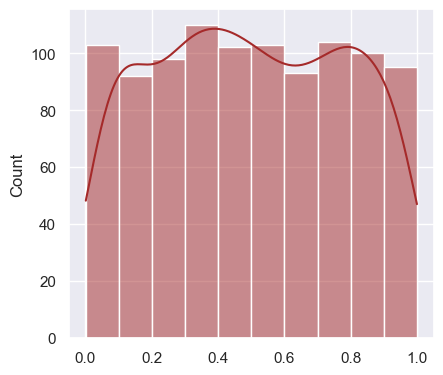

In [264]:
# мощность и корректность для CUPED на логарифмированной метрике
correctness = []
power = []

for i in tqdm(range(1000)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']

    vec_b_effect = vec_b * 1.05

    p_cor, p_power = ttest_ind(vec_a, vec_b)[1], ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Результаты лучше, чем в пункте 1 (этого задания)!

#### 3. Метрика `cart_added_cnt` с последующим раноговым преобразованием

In [265]:
# Используем данные за декабрь и сентябрь
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

# применяем cuped 
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])
display(shop_metrics_all_cuped.head(5))

/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/3523451292.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.1327605 0.1327605 0.1327605 ... 0.1327605 0.1327605 0.1327605]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)


,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.132761
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.132761
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.132761
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,0.132761
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,0.132761


In [266]:
shop_metrics_all_cuped_ranked = rank_transformation(
                            shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A'],
                            shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B'],
'cart_added_cnt_cuped')

In [267]:
# Применяем ранговую трансформацию к метрике cart_added_cnt_cuped
ranked = rank_transformation(
    shop_metrics_all_cuped[shop_metrics_all_cuped['group'] == 'A'],  
    shop_metrics_all_cuped[shop_metrics_all_cuped['group'] == 'B'],  
    'cart_added_cnt_cuped'
)

# Добавляем ранги обратно в исходный DataFrame
shop_metrics_all_cuped['cart_added_cnt_cuped'] = ranked['rank']
shop_metrics_all_cuped.head(20)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,100501.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,100501.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,100501.5
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,100501.5
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,100501.5
5,1515915625353400724,A,1,2,103.33,0.0,0.0,0,0,0,100501.5
6,1515915625353411684,B,1,1,20.27,0.0,0.0,0,0,0,100501.5
7,1515915625353416040,A,1,13,1861.21,0.0,0.0,0,0,0,100501.5
8,1515915625353439133,A,1,3,50.94,0.0,0.0,0,0,0,100501.5
9,1515915625353482553,A,1,52,8748.48,0.0,0.0,0,0,0,100501.5


In [268]:
correlation = shop_metrics_all['cart_added_cnt'].corr(shop_metrics_all['cart_added_cnt_covariate'])
print(f"Корреляция между метрикой и ковариатой: {correlation:.3f}")
print('__' * 50)

# Проверка равенства средних метрики до и после применения CUPED (разница уменьшения не большая)
ttest_original = ttest_ind(
    shop_metrics_all[shop_metrics_all.group == 'A']['cart_added_cnt'],
    shop_metrics_all[shop_metrics_all.group == 'B']['cart_added_cnt']
)
ttest_cuped = ttest_ind(
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped']
)

print(f'p-value оригинальной метрики: {ttest_original[1]}')
print(f'p-value метрики с CUPED: {ttest_cuped[1]}')

print('__' * 50)

# Видим, что среднее изменилось
print(f'Среднее: метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].mean()}, \
        Среднее: метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].mean()}')
print(f'Среднее: метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
        Среднее: метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}')

print('__' * 50)

# Видим, что дисперсия сильно увеличилась
print(f'Дисперсия: метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].var()}, \
        Дисперсия: метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].var()}')
print(f'Дисперсия: метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].var()}, \
        Дисперсия: метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].var()}')

print('__' * 50)

# Проверка равенства средних ковариаты в группах (равны похуже)
print(f'Ковариата A: {shop_metrics_all[shop_metrics_all.group == "A"]["cart_added_cnt_covariate"].mean()}, \
        Ковариата B: {shop_metrics_all[shop_metrics_all.group == "B"]["cart_added_cnt_covariate"].mean()}')

Корреляция между метрикой и ковариатой: 0.975
____________________________________________________________________________________________________
p-value оригинальной метрики: 0.1919716009958315
p-value метрики с CUPED: 0.14818114788143424
____________________________________________________________________________________________________
Среднее: метрика_cuped A: 111157.3299691882,         Среднее: метрика_cuped B: 111364.78283723022
Среднее: метрика без cuped A: 0.1350419058398685,         Среднее: метрика без cuped B: 0.1385521582733813
____________________________________________________________________________________________________
Дисперсия: метрика_cuped A: 1138307738.193268,         Дисперсия: метрика_cuped B: 1151768826.5589178
Дисперсия: метрика без cuped A: 0.3805867322090304,         Дисперсия: метрика без cuped B: 0.4247189893567569
____________________________________________________________________________________________________
Ковариата A: 0.14055748690723224,     

Возникло наоборт увеличение дисперсии и ожидаются результаты хуже чем в другим экспериментах в связи с нарушением почти все условий по метрикам.

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/3523451292.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.1327605 0.1327605 0.1327605 ... 0.1327605 0.1327605 0.1327605]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)
  0%|          | 1/1000 [00:00<05:56,  2.80it/s]/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/3523451292.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.1327605 0.1327605 0.1327605 ... 0.1327605 0.1327605 0.1327605]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)
  0%|          | 2/1000 [00:00<05:56,  2.80it/s]/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/3523451292.py:16: FutureWarning: Setting an item o

 power: 100.0% , correctness: 95.3%


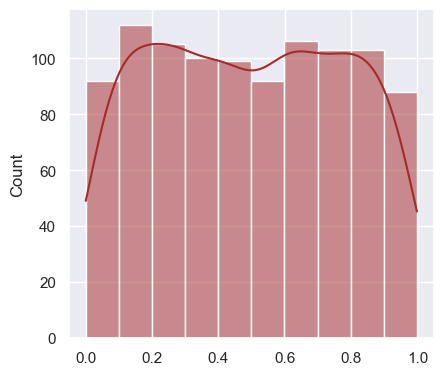

In [269]:
# мощность и корректность для CUPED на ранжированной метрике
correctness = []
power = []

for i in tqdm(range(1000)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']

    vec_b_effect = vec_b * 1.05

    p_cor, p_power = ttest_ind(vec_a, vec_b)[1], ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

### **3. Реализовать разбивку на бакеты любым (правильным) способом, оценить t-критерием и сравнить с результатом без бакетирования:**
- на логнормальном распределении (сгенерированные данные) (5 баллов)
- на метрике cart_added_cnt (5 баллов)

#### Реализация на `логнормальном распределении` (сгенерированные данные)

In [270]:
np.random.seed(42)  
n_samples = 10000

# Генерируем контрольную группу (A)
control_data = np.random.lognormal(mean=0, sigma=1, size=n_samples)

# Генерируем тестовую группу (B) с небольшим увеличением (например, на 2%)
effect_size = 1.02
test_data = np.random.lognormal(mean=0, sigma=1, size=n_samples) * effect_size

#  T-тест без бакетирования
t_stat_no_bucket, p_value_no_bucket = stats.ttest_ind(control_data, test_data)
print("Без бакетирования:")
print(f" t-статистика: {round(t_stat_no_bucket, 4)}")
print(f" p-value: {round(p_value_no_bucket, 4)}")

Без бакетирования:
 t-статистика: -1.7562
 p-value: 0.0791


In [271]:
#  Функция для разбиения на бакеты
def create_buckets(data, n_buckets=10):
    """
    Делим данные на n_buckets сегментов на основе процентилей.
    Возвращает список бакетов (каждый бакет - это срез из data).
    """
    bucket_edges = np.percentile(data, np.linspace(0, 100, n_buckets + 1))
    buckets = []
    for i in range(n_buckets):
        # Последний бакет включительно (<=), чтобы "закрыть" правый край
        if i == n_buckets - 1:
            mask = (data >= bucket_edges[i]) & (data <= bucket_edges[i + 1])
        else:
            mask = (data >= bucket_edges[i]) & (data < bucket_edges[i + 1])
        buckets.append(data[mask])
    return buckets

# T-тест с бакетированием
control_buckets = create_buckets(control_data, n_buckets=10)
test_buckets = create_buckets(test_data, n_buckets=10)

t_stats_buckets = []
p_values_buckets = []

for c_bucket, t_bucket in zip(control_buckets, test_buckets):
    t_stat, p_val = stats.ttest_ind(c_bucket, t_bucket)
    t_stats_buckets.append(t_stat)
    p_values_buckets.append(p_val)

print("\nС бакетированием (по каждому бакету):")
for i, (t_stat, p_val) in enumerate(zip(t_stats_buckets, p_values_buckets), start=1):
    print(f" Бакет {i}: t-стат = {round(t_stat, 4)}, p-value = {round(p_val, 4)}")



С бакетированием (по каждому бакету):
 Бакет 1: t-стат = -3.0031, p-value = 0.0027
 Бакет 2: t-стат = -9.6833, p-value = 0.0
 Бакет 3: t-стат = -8.8714, p-value = 0.0
 Бакет 4: t-стат = -8.9468, p-value = 0.0
 Бакет 5: t-стат = -10.6024, p-value = 0.0
 Бакет 6: t-стат = -8.4263, p-value = 0.0
 Бакет 7: t-стат = -8.6707, p-value = 0.0
 Бакет 8: t-стат = -9.7688, p-value = 0.0
 Бакет 9: t-стат = -5.7869, p-value = 0.0
 Бакет 10: t-стат = -1.0799, p-value = 0.2803


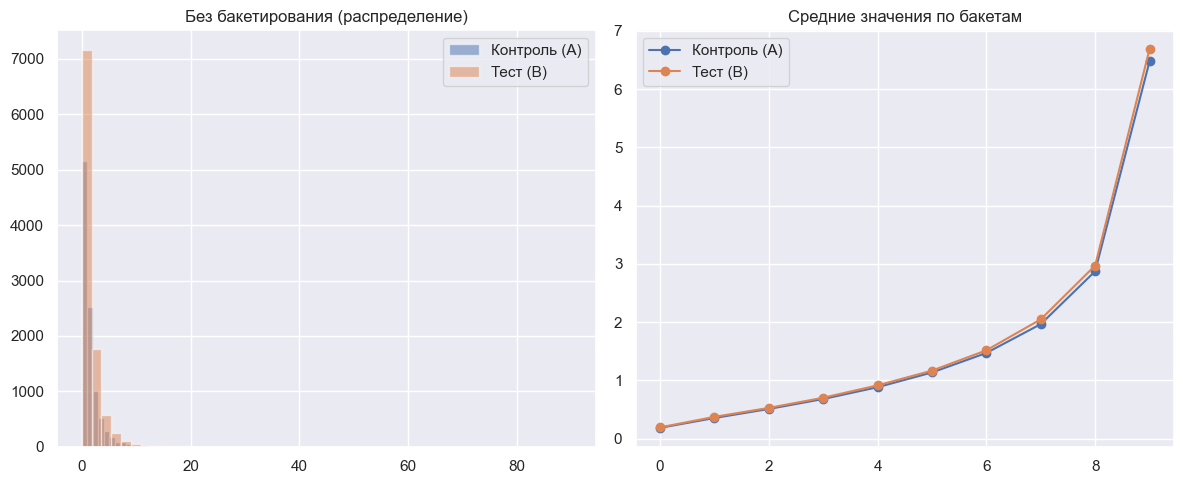

In [272]:
plt.figure(figsize=(12, 5))

# Гистограммы без бакетирования
plt.subplot(1, 2, 1)
plt.hist(control_data, bins=50, alpha=0.5, label='Контроль (A)')
plt.hist(test_data, bins=50, alpha=0.5, label='Тест (B)')
plt.title('Без бакетирования (распределение)')
plt.legend()

# Средние по бакетам
means_control = [np.mean(b) if len(b) > 0 else 0 for b in control_buckets]
means_test = [np.mean(b) if len(b) > 0 else 0 for b in test_buckets]
plt.subplot(1, 2, 2)
x = range(len(means_control))
plt.plot(x, means_control, marker='o', label='Контроль (A)')
plt.plot(x, means_test, marker='o', label='Тест (B)')
plt.title('Средние значения по бакетам')
plt.legend()

plt.tight_layout()
plt.show()

Без бакетирования существенной разницы не видно (p-value≈0.08). Однако при разбиении на сегменты в большинстве бакетов проявляется статистически значимая разница, что говорит о сильной скошенности (логнормальности) распределения. На графиках видно, что большая часть наблюдений сосредоточена у нуля, а хвост распределения длинный; из-за этого при анализе «в целом» эффект «размывается», тогда как по отдельным бакетам разница становится заметной.

#### Реализация на метрике `cart_added_cnt`

In [273]:
# 1. Разделяем данные по группам
df_a = shop_metrics_new[shop_metrics_new['group'] == 'A']
df_b = shop_metrics_new[shop_metrics_new['group'] == 'B']

# 2. Функция для создания бакетов
def create_buckets(data, n_buckets=3):
    bucket_edges = np.percentile(data, np.linspace(0, 100, n_buckets + 1))
    buckets = [data[(data >= bucket_edges[i]) & (data < bucket_edges[i + 1])] for i in range(n_buckets)]
    return buckets

# 3. Основной анализ
print("Статистика до бакетирования:")
print(f"Среднее A: {df_a['cart_added_cnt'].mean():.4f}, B: {df_b['cart_added_cnt'].mean():.4f}")
print(f"Дисперсия A: {df_a['cart_added_cnt'].var():.4f}, B: {df_b['cart_added_cnt'].var():.4f}")

t_stat, p_val = stats.ttest_ind(df_a['cart_added_cnt'], df_b['cart_added_cnt'])
print(f"T-тест: t={t_stat:.4f}, p={p_val:.4f}\n")

Статистика до бакетирования:
Среднее A: 0.1350, B: 0.1386
Дисперсия A: 0.3806, B: 0.4247
T-тест: t=-1.3048, p=0.1920



In [274]:
# 4. Бакетирование и анализ по бакетам
buckets_a = create_buckets(df_a['cart_added_cnt'])
buckets_b = create_buckets(df_b['cart_added_cnt'])

print("Результаты по бакетам:")
for i, (bucket_a, bucket_b) in enumerate(zip(buckets_a, buckets_b), start=1):
    if len(bucket_a) == 0 or len(bucket_b) == 0:
        print(f"Бакет {i}: недостаточно данных.")
        continue

    # T-тест внутри бакета
    t_stat, p_val = stats.ttest_ind(bucket_a, bucket_b)
    print(f"Бакет {i}:")
    print(f"  Среднее A: {bucket_a.mean():.4f}, B: {bucket_b.mean():.4f}")
    print(f"  T-тест: t={t_stat:.4f}, p={p_val:.4f}")

Результаты по бакетам:
Бакет 1: недостаточно данных.
Бакет 2: недостаточно данных.
Бакет 3:
  Среднее A: 0.1345, B: 0.1379
  T-тест: t=-1.3287, p=0.1840


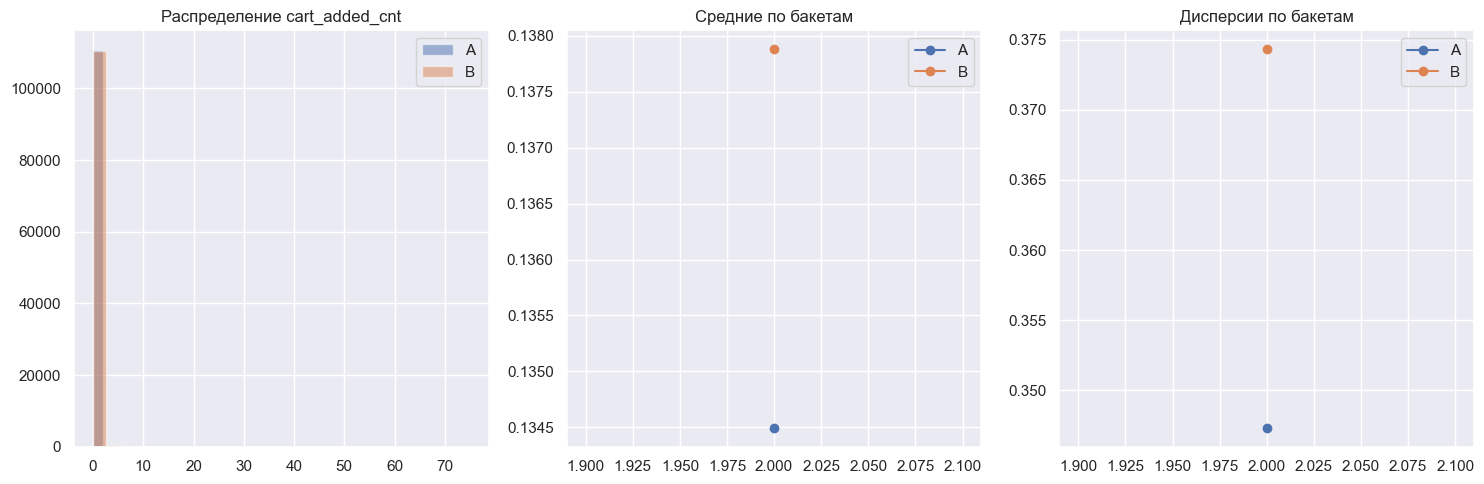

In [275]:
# Визуализация
plt.figure(figsize=(15, 5))

# Распределение cart_added_cnt
plt.subplot(131)
plt.hist(df_a['cart_added_cnt'], bins=30, alpha=0.5, label='A')
plt.hist(df_b['cart_added_cnt'], bins=30, alpha=0.5, label='B')
plt.title('Распределение cart_added_cnt')
plt.legend()

# Средние по бакетам
plt.subplot(132)
means_a = [np.mean(b) if len(b) > 0 else np.nan for b in buckets_a]
means_b = [np.mean(b) if len(b) > 0 else np.nan for b in buckets_b]
plt.plot(range(len(means_a)), means_a, 'o-', label='A')
plt.plot(range(len(means_b)), means_b, 'o-', label='B')
plt.title('Средние по бакетам')
plt.legend()

# Дисперсии по бакетам
plt.subplot(133)
vars_a = [np.var(b) if len(b) > 0 else np.nan for b in buckets_a]
vars_b = [np.var(b) if len(b) > 0 else np.nan for b in buckets_b]
plt.plot(range(len(vars_a)), vars_a, 'o-', label='A')
plt.plot(range(len(vars_b)), vars_b, 'o-', label='B')
plt.title('Дисперсии по бакетам')
plt.legend()

plt.tight_layout()
plt.show()

#### Без бакетирования:
- Среднее значение метрики `cart_added_cnt` в группе A: **0.1350**, в группе B: **0.1386**.
- Разница между группами незначительна (p-value = 0.1920 > 0.05), то есть **статистически значимых различий нет**.

#### С бакетированием:
- В большинстве бакетов данных недостаточно для анализа (пустые бакеты).
- В единственном бакете с данными (Бакет 3):
  - Среднее значение в группе A: **0.1345**, в группе B: **0.1379**.
  - Разница также незначительна (p-value = 0.1840 > 0.05).

#### Итог:
- **Результаты не показывают значимого эффекта** от изменений в группе B.
- **Бакетирование не дало дополнительных insights** из-за недостатка данных.

### **4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:**
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)
подсчитать результаты для случая без постстратификации и с постстратификацией. (дисперсию и среднее)
- проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)

In [276]:
# Загружаем данные
shop_metrics_old = pd.read_csv('./data/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('./data/shop_df_users.csv').drop(columns='Unnamed: 0')

In [277]:
# Объединяем метрики с информацией о пользователях
shop_w_features = pd.merge(shop_metrics_old, shop_users_info, on=['user_id'], how='left')

# Разбиваем возраст на группы
bins = [18, 24, 45, 60, 75, np.inf]
labels = ['18-24', '25-45', '46-60', '61-75', '76+']
shop_w_features['age_group'] = pd.cut(shop_w_features['user_age'], bins=bins, labels=labels, right=True)
shop_w_features

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,user_age,user_sex,age_group
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0,55,f,46-60
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0,58,m,46-60
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0,23,f,18-24
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0,33,m,25-45
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0,26,f,25-45
...,...,...,...,...,...,...,...,...,...,...,...,...
406858,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,76,m,76+
406859,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,34,m,25-45
406860,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,62,m,61-75
406861,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,48,f,46-60


In [278]:
display(shop_w_features.groupby('group')['age_group'].value_counts())

group  age_group
A      25-45        63972
       46-60        45657
       61-75        44940
       76+          27374
       18-24        18386
B      25-45        63929
       61-75        45495
       46-60        45394
       76+          27444
       18-24        18279
Name: count, dtype: int64

In [279]:
# t-тест
t_stat, p_value = stats.ttest_ind(
    shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'],
    shop_w_features[shop_w_features.group == 'B']['cart_added_cnt']
)
print(f"t-статистика: {t_stat:.4f}, p-value: {p_value:.4f}")

# Относительное изменение среднего
relative_change = (
    (shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'].mean() - 
     shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].mean()) /
    shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].mean() * 100
)
print(f"Относительное изменение среднего: {relative_change:.2f}%")

# Стандартное отклонение
std_A = shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].std()
std_B = shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'].std()
print(f"Стандартное отклонение (A): {std_A:.4f}, (B): {std_B:.4f}")

t-статистика: -0.7332, p-value: 0.4634
Относительное изменение среднего: 1.12%
Стандартное отклонение (A): 0.5767, (B): 0.5988


In [289]:
# Считаем веса для постстратификации
N = shop_w_features['user_id'].nunique()

strats_weights = {}

for i in range(0, shop_w_features['age_group'].nunique()):
    key = shop_w_features['age_group'].value_counts().index[i]
    strats_weights[key] = shop_w_features['age_group'].value_counts()[i] / N
    
# Классический результат без постстратификации
mean_a = shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].mean()
mean_b = shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'].mean()
std_a = shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].std()
std_b = shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'].std()

effect = (mean_b - mean_a) / mean_a * 100
print(f'Без постстратификации: effect: {effect:.2f}%, std_a: {std_a:.2f}, std_b: {std_b:.2f}')

p_value_classic = stats.ttest_ind(
    shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'],
    shop_w_features[shop_w_features.group == 'B']['cart_added_cnt']
)[1]


print(f'p-value без постстратификации: {p_value_classic:.4f}')
print('Эффект:', effect)

Без постстратификации: effect: 1.12%, std_a: 0.58, std_b: 0.60
p-value без постстратификации: 0.4634
Эффект: 1.1242734540045785


/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/2817893904.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strats_weights[key] = shop_w_features['age_group'].value_counts()[i] / N
/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/2817893904.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strats_weights[key] = shop_w_features['age_group'].value_counts()[i] / N
/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_9188/2817893904.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels 

In [290]:
# Расчет среднего и дисперсии с постстратификацией
mean_a = 0
mean_b = 0
var_a = 0
var_b = 0

for age_group in labels:
    mean_a += shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == age_group)]['cart_added_cnt'].mean() * strats_weights[age_group]
    mean_b += shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == age_group)]['cart_added_cnt'].mean() * strats_weights[age_group]
    
    var_a += shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == age_group)]['cart_added_cnt'].var() * strats_weights[age_group]
    var_b += shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == age_group)]['cart_added_cnt'].var() * strats_weights[age_group]

std_a = np.sqrt(var_a)
std_b = np.sqrt(var_b)

# Вывод результатов
print(f"Среднее с постстратификацией (A): {mean_a:.4f}, (B): {mean_b:.4f}")
print(f"Стандартное отклонение с постстратификацией (A): {std_a:.4f}, (B): {std_b:.4f}")

# Проверка мощности и корректности t-критерия
n_a = len(shop_w_features[shop_w_features.group == 'A'])
n_b = len(shop_w_features[shop_w_features.group == 'B'])

t_stat, p_value = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)
print(f"t-статистика с постстратификацией: {t_stat:.4f}, p-value: {p_value:.4f}")

# Сравнение с базовым случаем
t_stat_base, p_value_base = stats.ttest_ind(
    shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'],
    shop_w_features[shop_w_features.group == 'B']['cart_added_cnt']
)
print(f"t-статистика без постстратификации: {t_stat_base:.4f}, p-value: {p_value_base:.4f}")

Среднее с постстратификацией (A): 0.1187, (B): 0.1197
Стандартное отклонение с постстратификацией (A): 0.5744, (B): 0.5838
t-статистика с постстратификацией: -0.5810, p-value: 0.5612
t-статистика без постстратификации: -0.7332, p-value: 0.4634


Результаты показывают, что:

- **Без постстратификации**:  
  Эффект ≈ 1.12%, p-value = 0.46.  
- **С постстратификацией**:  
  p-value = 0.56.  

Разница между группами по метрике **cart_added_cnt** не достигает статистической значимости (p-value > 0.05).  

**Вывод:**  
Несмотря на небольшое увеличение среднего в группе B, величина эффекта слишком мала и «растворяется» в шумах данных. Постстратификация слегка скорректировала оценку среднего и стандартного отклонения, но не изменила итоговый вывод — статистически значимого различия не выявлено.

### Итог:
Метрика **`cart_added_cnt`** имеет неравномерное распределение, что затруднило проведение некоторых тестов и экспериментов. Наиболее эффективным подходом оказалось **логарифмирование метрики + CUPED**, который показал отличные результаты:

- **Power (Мощность): 100.0%**  
  Тест корректно обнаруживает эффект, если он существует.  
- **Correctness (Корректность): 96.2%**  
  Тест не допускает ложноположительных результатов в 96.2% случаев.  
